In [1]:
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, multivariate_normal
from tqdm import tqdm

from models.fno import FNO
from models.losses import LpLoss, H1Loss

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def h(x):
    w_max = 5
    if isinstance(x, torch.Tensor):
        w = w_max * torch.rand((x.shape[-1], 1)).to(x.device)
    else:
        w = w_max * np.random.rand(x.shape[-1], 1)
    return (x @ w)[...,0]

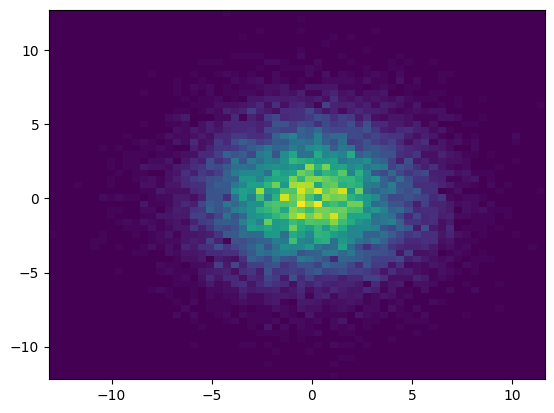

In [4]:
N = 20000
d = 2
mu = 0
sigma = 3
X = torch.normal(mu * torch.ones(N, d), sigma * torch.ones(N, d))
_ = plt.hist2d(X[:, 0], X[:, 1], bins=60)

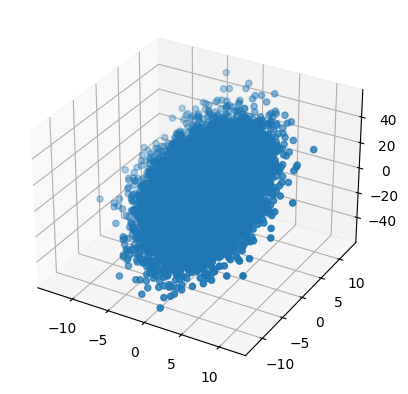

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:, 0], X[:, 1], h(X))

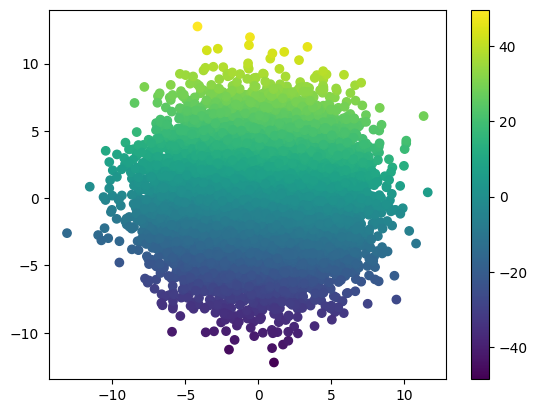

In [6]:
fig = plt.figure()

plt.scatter(X[:, 0], X[:, 1], c=h(X))
plt.colorbar()

In [7]:
def dm(X, h, ϕ_prev, ϵ=0.01, L=1000):
    
    X1_idx, X2_idx = torch.meshgrid(torch.arange(len(X)), torch.arange(len(X)), indexing='ij')
    X1, X2 = X[X1_idx], X[X2_idx]
    g = torch.exp(-torch.square(X1 - X2).sum(-1)/(4*ϵ))

    g_rowsum = torch.sum(g, dim=1)
    g_1, g_2 = torch.meshgrid(g_rowsum, g_rowsum, indexing='ij')
    k = g/(torch.sqrt(g_1)*torch.sqrt(g_2))

    d = torch.sum(k, axis=1)
    T = k/d[:, None]
    π = d/d.sum()

    hx_hat = torch.sum(π*h(X))

    ϕ = ϕ_prev

    for t in tqdm(range(1, L+1)):
        ϕ = (T * ϕ).sum(axis=1) + ϵ*(h(X) - hx_hat)
    
    return ϕ

In [8]:
def phi(x):
    return sigma**2 * h(x)

In [9]:
N = 20000
L = 10000
X = X.to(device)
# X = torch.normal(mu * torch.ones(N, d), sigma * torch.ones(N, d)).to(device)
ϕ_pred = dm(X, h, torch.randn(len(X)).to(device), L=L)
error = F.l1_loss(ϕ_pred, phi(X)).item()
print(f"N: {N} Error: {error:.4f}")

100%|██████████| 10000/10000 [01:11<00:00, 139.48it/s]

N: 20000 Error: 62.2184


In [10]:
X_cpu = X.cpu().numpy()
mask = (X_cpu[:, 0]>-5)&(X_cpu[:, 0]<5) & (X_cpu[:, 1]>-5)&(X_cpu[:, 1]<5)
X_cpu_sel = X_cpu[mask]
ϕ_pred_sel = ϕ_pred[mask].cpu().numpy()

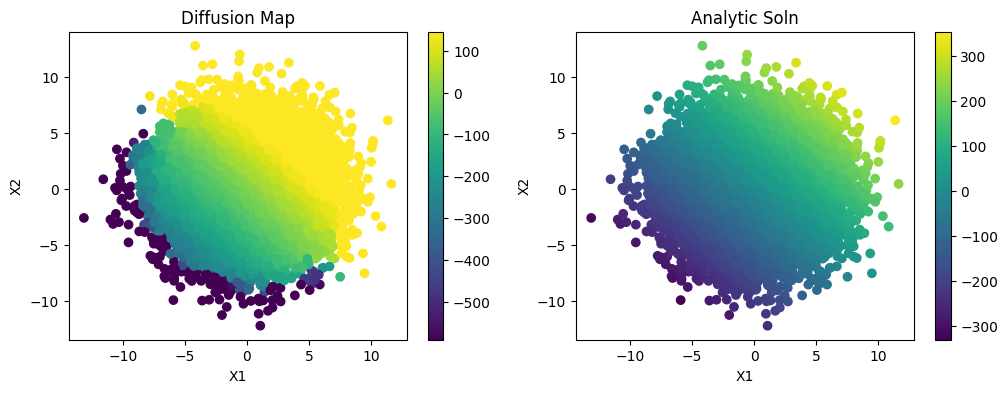

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

im1 = ax[0].scatter(X_cpu[:, 0], X_cpu[:, 1], 
                    c=np.clip(ϕ_pred.cpu().numpy(), a_min=phi(X_cpu).min(), a_max=phi(X_cpu).max()), 
                    marker='o', label='DiffusionMap')
ax[0].set_xlabel('X1')
ax[0].set_ylabel('X2')
ax[0].set_title('Diffusion Map')

im2 = ax[1].scatter(X_cpu[:, 0], X_cpu[:, 1], c=phi(X_cpu), marker='o', label='AnalyticSoln')
ax[1].set_xlabel('X1')
ax[1].set_ylabel('X2')
ax[1].set_title('Analytic Soln')

fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
# ax.set_zlabel('$\phi$')
# ax.legend()
# ax[i, j%m].set_title(f"L: {L} N: {N} MAE: {error:.4f}")

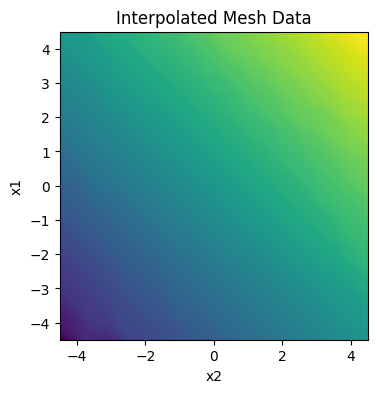

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Sample point cloud data (replace this with your actual data)
# Assuming point cloud data is in the form of a 2D numpy array with columns [x, y, value]
point_cloud_data = np.concatenate([X_cpu_sel, ϕ_pred_sel[:, None]], axis=1)

# Extract x, y, and values
x = point_cloud_data[:, 0]
y = point_cloud_data[:, 1]
values = point_cloud_data[:, 2]

# Define the grid over which you want to interpolate
N = 200
x_resample = np.linspace(min(x), max(x), N)
y_resample = np.linspace(min(y), max(y), N)
grid_x, grid_y = np.meshgrid(x_resample, 
                             y_resample, 
                             indexing='ij')

# Perform interpolation
start_idx = int(0.05 * N)
end_idx = int(0.95 * N)
grid_values = griddata((x, y), values, (grid_x, grid_y), method='linear')
grid_values = grid_values[start_idx:end_idx, start_idx:end_idx]
x_resample = x_resample[start_idx:end_idx]
y_resample = y_resample[start_idx:end_idx]

grid_x, grid_y = np.meshgrid(x_resample, 
                             y_resample, 
                             indexing='ij')

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.imshow(grid_values, extent=(min(x_resample), max(x_resample), 
                               min(y_resample), max(y_resample)), origin='lower')
ax.set_title('Interpolated Mesh Data')
ax.set_xlabel('x2')
ax.set_ylabel('x1')
# plt.colorbar()

ϕx = grid_values

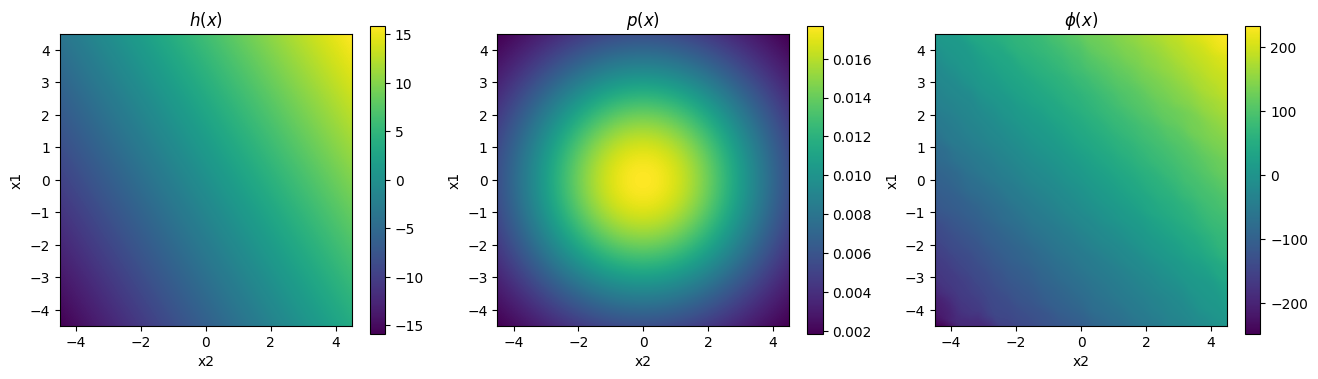

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
grid = np.concatenate([grid_x.flatten()[:, None], grid_y.flatten()[:, None]], axis=1)
hx = h(grid).reshape(grid_x.shape)
im = ax[0].imshow(hx, extent=(min(x_resample), max(x_resample),
                      min(y_resample), max(y_resample)), origin='lower')
ax[0].set_xlabel('x2')
ax[0].set_ylabel('x1')
ax[0].set_title('$h(x)$')
fig.colorbar(im, orientation='vertical')


grid = np.concatenate([grid_x.flatten()[:, None], grid_y.flatten()[:, None]], axis=1)
dist = multivariate_normal(np.ones(d)*mu, np.identity(d)*sigma**2)
px = dist.pdf(grid).reshape(grid_x.shape)

im = ax[1].imshow(px, extent=(min(x_resample), max(x_resample),
                      min(y_resample), max(y_resample)), origin='lower')
ax[1].set_xlabel('x2')
ax[1].set_ylabel('x1')
ax[1].set_title('$p(x)$')

fig.colorbar(im, orientation='vertical')


im = ax[2].imshow(ϕx, extent=(min(x_resample), max(x_resample),
                      min(y_resample), max(y_resample)), origin='lower')
ax[2].set_xlabel('x2')
ax[2].set_ylabel('x1')
ax[2].set_title('$\phi(x)$')
fig.colorbar(im, orientation='vertical')


### Create Dataset

In [14]:
grid_x = torch.from_numpy(np.concatenate([grid_x[..., None], grid_y[..., None]], axis=-1)).to(device)
grid_h = torch.from_numpy(hx).to(device)[...,None]
grid_p = torch.from_numpy(px).to(device)[...,None]
grid_ϕ = torch.from_numpy(ϕx).to(device)[...,None]

In [15]:
M, N, D = grid_x.shape

w_i, w_j = (32, 32)


tensor_data_a = []
tensor_data_u = []

grid_a = torch.concat([grid_x, grid_h, grid_p], dim=-1)
grid_a = torch.permute(grid_a, dims=(2, 0, 1))
grid_u = torch.permute(grid_ϕ, dims=(2, 0, 1))

for i in range(0, M-w_i+1, w_i//2):
    for j in range(0, N-w_j+1, w_j//2):
        tensor_data_a.append(grid_a[:, i:i+w_i, j:j+w_j])
        tensor_data_u.append(grid_u[:, i:i+w_i, j:j+w_j])


ax_tensor = torch.stack(tensor_data_a)
ux_tensor = torch.stack(tensor_data_u)

ux_tensor.shape, ax_tensor.shape

(torch.Size([100, 1, 32, 32]), torch.Size([100, 4, 32, 32]))

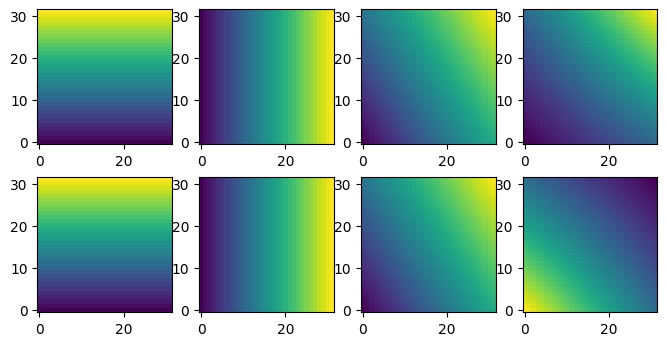

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))

axs[0, 0].imshow(ax_tensor[0, 0,...].cpu().numpy(), origin='lower')
axs[0, 1].imshow(ax_tensor[0, 1,...].cpu().numpy(), origin='lower')
axs[0, 2].imshow(ax_tensor[0, 2,...].cpu().numpy(), origin='lower')
axs[0, 3].imshow(ax_tensor[0, 3,...].cpu().numpy(), origin='lower')

axs[1, 0].imshow(ax_tensor[-1, 0].cpu().numpy(), origin='lower')
axs[1, 1].imshow(ax_tensor[-1, 1].cpu().numpy(), origin='lower')
axs[1, 2].imshow(ax_tensor[-1, 2].cpu().numpy(), origin='lower')
axs[1, 3].imshow(ax_tensor[-1, 3].cpu().numpy(), origin='lower')

In [17]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [18]:
class DictDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        return {'x': x, 'y': y}
    
    def __len__(self):
        return len(self.data)

In [19]:
train_ds = DictDataset(ax_tensor, ux_tensor)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [20]:
for batch in train_dl:
    print(batch['x'].shape, batch['y'].shape)

torch.Size([32, 4, 32, 32]) torch.Size([32, 1, 32, 32])
torch.Size([32, 4, 32, 32]) torch.Size([32, 1, 32, 32])
torch.Size([32, 4, 32, 32]) torch.Size([32, 1, 32, 32])
torch.Size([4, 4, 32, 32]) torch.Size([4, 1, 32, 32])


In [21]:
def training_loop(model, train_dl, train_loss, optimizer, scheduler, n_epochs=500):

    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):

        avg_loss = 0
        avg_lasso_loss = 0
        model.train()
        train_err = 0.0

        avg_test_loss = 0
        test_err = 0.0

        for idx, sample in enumerate(train_dl):

            # load everything from the batch onto self.device if 
            # no callback overrides default load to device

            for k,v in sample.items():
                if hasattr(v, 'to'):
                    sample[k] = v.to(device)

            optimizer.zero_grad(set_to_none=True)
            out = model(**sample)

            loss = 0.

            if isinstance(out, torch.Tensor):
                loss = train_loss(out.float(), **sample)
            elif isinstance(out, dict):
                loss += train_loss(**out, **sample)

            del out

            loss.backward()

            optimizer.step()
            train_err += loss.item()

            with torch.no_grad():
                avg_loss += loss.item()

        if (epoch + 1) % 5:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_err)
            else:
                scheduler.step()

        train_err /= len(train_dl)
        avg_loss  /= n_epochs


        train_losses.append(avg_loss)
        # test_losses.append(avg_test_loss)

        # print(f'Epoch: {epoch+1} loss: {avg_loss:.4f}  test loss: {avg_test_loss:.4f} lr: {scheduler.get_last_lr()[0]:.4f}, {optimizer.state_dict()["param_groups"][0]["lr"]:.4f}')
        if epoch % 10 == 0:
            print(f'Epoch: {epoch+1} loss: {avg_loss:.4f} lr: {scheduler.get_last_lr()[0]:.4f}, {optimizer.state_dict()["param_groups"][0]["lr"]:.4f}')
        
    return model

In [22]:
def train_model(train_loader, n_modes=(16, 10), in_channels=2, hidden_channels=64, 
                 projection_channels=64, n_epochs=200):
    
    # Losses
    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)

    train_loss = h1loss
    eval_losses={'h1': h1loss, 'l2': l2loss}
    
    # Model configuration
    n_modes = n_modes
    model = FNO(n_modes=n_modes, in_channels=in_channels, hidden_channels=hidden_channels, 
                 projection_channels=projection_channels).double()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=1e-4,
                                weight_decay=1e-4)
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    print(model)
    
    model = training_loop(model, train_loader, 
                          train_loss, optimizer, 
                          scheduler, n_epochs=n_epochs)
    
    return model

In [23]:
model = train_model(train_dl, in_channels=4, n_modes=(16, 16), n_epochs=500)

FNO(
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(4, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (convs): SpectralConv(
    (weight): ModuleList(
      (0-3): 4 x ComplexDenseTensor(shape=torch.Size([64, 64, 16, 9]), rank=None)
    )
  )
  (fno_skips): ModuleList(
    (0-3): 4 x Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
)
Epoch: 1 loss: 0.2000 lr: 0.0001, 0.0001
Epoch: 11 loss: 0.1988 lr: 0.0001, 0.0001
Epoch: 21 loss: 0.1866 lr: 0.0001, 0.0001
Epoch: 31 loss: 0.1190 lr: 0.0001, 0.0001
Epoch: 41 loss: 0.0497 lr: 0.0001, 0.0001
Epoch: 51 loss: 0.0433 lr: 0.0001, 0.0001
Epoch: 61 loss: 0.0398 lr: 0.0001, 0.0001
Epoch: 71 loss: 0.0367 lr: 0.0001, 0.0001
Epoch: 81 loss: 0.0334 lr: 0.0001, 0.0001
Epoch: 91 loss: 

In [24]:
test_ax = grid_a[None,...].to(device)
test_ux = grid_u[None,...].to(device)

test_ax.shape, test_ux.shape

(torch.Size([1, 4, 180, 180]), torch.Size([1, 1, 180, 180]))

In [25]:
pred_ux = model(test_ax)

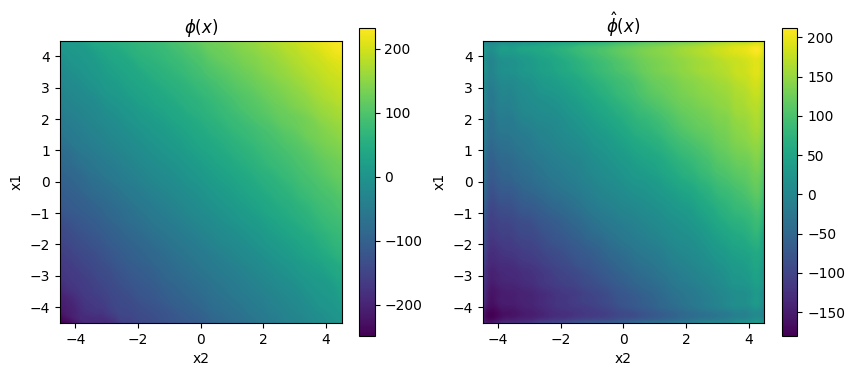

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

im = ax[0].imshow(test_ux.cpu().numpy()[0, 0], extent=(min(x_resample), max(x_resample),
                      min(y_resample), max(y_resample)), origin='lower')
ax[0].set_xlabel('x2')
ax[0].set_ylabel('x1')
ax[0].set_title('$\phi(x)$')
fig.colorbar(im, orientation='vertical')


im = ax[1].imshow(pred_ux.detach().cpu().numpy()[0, 0], extent=(min(x_resample), max(x_resample),
                      min(y_resample), max(y_resample)), origin='lower')
ax[1].set_xlabel('x2')
ax[1].set_ylabel('x1')
ax[1].set_title('$\hat{\phi}(x)$')
fig.colorbar(im, orientation='vertical')